<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/MobNet100x100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Conv2D,ConvLSTM2D,BatchNormalization,Conv3D, Conv1D, GlobalAveragePooling2D, GRU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate,Reshape
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
#from test_utils import summary, comparator
import seaborn as sns
warnings.filterwarnings('ignore')

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/FV_all_in_one.csv'
df = pd.read_csv(path)
df = df.drop(df.columns[[0]], axis=1)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'] , unit="s")
#df.set_index(df['Datetime'] ,inplace=True)
#df = df.drop(df.columns[[0]], axis=1)
#df.head()
dfdata = df.iloc[:,1:10001].to_numpy()
print(dfdata.shape)
arr3d = dfdata.reshape(8928, 100, 100)
shapeData = arr3d.shape
print(shapeData)

(8928, 10000)
(8928, 100, 100)


In [ ]:
def shapingInputs( arr3d , numInps ):
  shapeData = arr3d.shape
  X = np.zeros(( shapeData[0]-numInps , numInps , shapeData[1] , shapeData[2] ))
  Y = arr3d[numInps :]

  for i in range(0,shapeData[0]-numInps):
    X[i] = arr3d[i:i+numInps]

  return X/2000 , Y/2000

In [ ]:
numInps = 3
length = shapeData[0]
st = 0 # start 
w  = 100 # width
X ,Y = shapingInputs( arr3d[10:,st:st+w,st:st+w] , numInps )
print('X.shape : ',X.shape)
print('Y.shape : ',Y.shape)
Y1 = Y.reshape(-1, w, w,1)
print('Y1.shape : ',Y1.shape)

X.shape :  (8915, 3, 100, 100)
Y.shape :  (8915, 100, 100)
Y1.shape :  (8915, 100, 100, 1)


In [ ]:
# Make sure images have shape (28, 28, 1)
x_train = X.transpose((0,2,3,1))
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")


x_train shape: (8915, 100, 100, 3)
8915 train samples


## Data Visualizing...

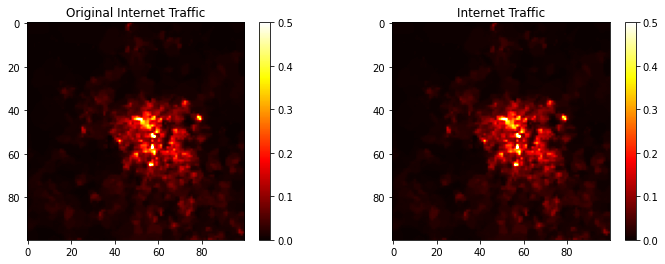

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
Z1 = x_train[1,:,:,2]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.show()

plt.subplot(1, 2, 2)
Z2 = Y1[0,:,:,0]
plt.imshow(Z2,cmap="hot")
plt.title("Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.show()

## Model

**Keras: Multiple Inputs and Mixed Data**

```
# # define two sets of inputs
  inputA = Input(shape=(32,))
  inputB = Input(shape=(128,))
  # the first branch operates on the first input
  x = Dense(8, activation="relu")(inputA)
  x = Dense(4, activation="relu")(x)
  x = Model(inputs=inputA, outputs=x)
  # the second branch opreates on the second input
  y = Dense(64, activation="relu")(inputB)
  y = Dense(32, activation="relu")(y)
  y = Dense(4, activation="relu")(y)
  y = Model(inputs=inputB, outputs=y)
  # combine the output of the two branches
  combined = concatenate([x.output, y.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = Dense(2, activation="relu")(combined)
  z = Dense(1, activation="linear")(z)
  # our model will accept the inputs of the two branches and
  # then output a single value

model = Model(inputs=[x.input, y.input], outputs=z)
```



In [ ]:
def mySOModel(input_shape=(100,100,3)):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''    
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=True,
                                               weights='imagenet')
    base_model.layers.pop()
    base_model = Model(base_model.layers[2].input, base_model.layers[-3].output)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = Input(shape=input_shape) 
    x = inputs
    # print(x.shape)
    x = ZeroPadding2D(padding=6)(x)
    # print(x.shape)

    conv = Conv2D(32, # Number of filters
              3,# Kernel size   
              activation='relu',
              padding='same',
              kernel_initializer= 'he_normal')(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(conv, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x =  GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x =  Dropout(0.2)(x)

    #x = Dense(units=4320, activation='tanh')(x)
    # print(x.shape)
    x =  Reshape((1,-1))(x)
        

    x =  LSTM(256,activation='relu',return_sequences=True)(x)
    #x =  tfl.LSTM(20,activation='relu',return_sequences=True)(x)
    x =  Dense(512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = GRU(units=1024,return_sequences=True,go_backwards=True,unroll=True)(x)
    x = Dense(units=10000, activation='relu')(x)
    x =  Reshape((100,100))(x)

    ### END CODE HERE
    
    model = tf.keras.Model(inputs, x)
    
    return model

In [ ]:
img_height = 100
img_width = 100
num_channels = 3

model = mySOModel((img_height, img_width, num_channels))

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 112, 112, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 model_2 (Functional)        (None, 7, 7, 1280)        2257120   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0   

## Train

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=["MeanSquaredError"])

In [ ]:
model.optimizer="adam"

In [ ]:
model.fit(x_train[144*13:144*18], Y[144*13:144*18], epochs =2 , batch_size = 16, validation_split=0.2)

Epoch 1/2
36/36 [==============================] - 103s 3s/step - loss: 1.1370e-04 - mean_squared_error: 1.1370e-04 - val_loss: 1.5572e-04 - val_mean_squared_error: 1.5572e-04
Epoch 2/2
36/36 [==============================] - 85s 2s/step - loss: 1.1161e-04 - mean_squared_error: 1.1161e-04 - val_loss: 1.6187e-04 - val_mean_squared_error: 1.6187e-04


In [ ]:
#model.save('/content/gdrive/MyDrive/Data_Set/MobNet100x100_0220_05.model')
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Set/MobNet100x100_0220_05.model")

In [ ]:
# trainPredict = model.predict(x_train[3200:4000])
# trainPredict = trainPredict.reshape(-1,1)
# print(trainPredict.shape)

In [ ]:
start = 144*13
le = 144*5
valPredict = model.predict(x_train[start:start+le])
yout = Y[start : start + valPredict.shape[0]]
print('pred shape = ',valPredict.shape)
print('yout shape = ',yout.shape)

23/23 [==============================] - 23s 1s/step
pred shape =  (720, 100, 100)
yout shape =  (720, 100, 100)


In [ ]:
# Save output


# preded = valPredict.reshape((-1))
# pd.DataFrame(preded).to_csv('/content/gdrive/MyDrive/Data_Set/predicted100x100.csv')


# dfff = pd.DataFrame(preded)
# rearr = dfff.to_numpy()
# reCre = rearr.reshape((-1,100,100))

In [ ]:
# i = 45
# fig = plt.figure(figsize=(24, 6))
# plt.subplot(1, 3, 1)
# Z1 = valPredict[i,:,:]
# plt.imshow(Z1,cmap="hot")
# plt.title("Original Internet Traffic")
# plt.clim( 0,.5)
# plt.colorbar()
# #plt.show()

# plt.subplot(1, 3, 2)
# Z2 = reCre[i,:,:]
# Z4 = Z2[65:95,40:70]
# plt.imshow(Z2,cmap="hot")
# plt.title("Predicted Internet Traffic")
# plt.clim( 0,.5)
# plt.colorbar()

# plt.subplot(1, 3, 3)
# Z3 = abs(Z2-Z1)
# plt.imshow(Z3,cmap="hot")
# plt.title("Error of The Predicted Internet Traffic")
# plt.clim( 0,.5)
# plt.colorbar()
# #plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio15x15_01_compare.png',transparent=True)
# plt.show()


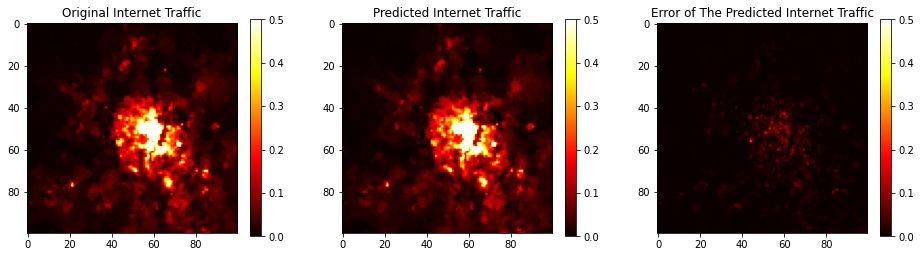

In [ ]:
i = 60
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
Z1 = yout[i,:,:]
plt.imshow(Z1,cmap="hot")
plt.title("Original Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.show()

plt.subplot(1, 3, 2)
Z2 = valPredict[i,:,:]
Z4 = Z2[65:95,40:70]
plt.imshow(Z2,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()

plt.subplot(1, 3, 3)
Z3 = abs(Z2-Z1)
plt.imshow(Z3,cmap="hot")
plt.title("Error of The Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
#plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spatio100x100/Spatio100x100_'+ str(i) +'_compare.png',transparent=True)
plt.show()


In [ ]:
print(Z3.max())
print(Z3.min())
print('pred shape = ',valPredict.shape)

0.2579772572727782
1.8456813166145558e-06
pred shape =  (720, 100, 100)


In [ ]:
def absError(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)


def msep(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)

def absErrorOne(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/ypred.shape[0]
  return np.sum(dif)


def msepOne(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/ypred.shape[0]
  return np.sum(dif)

In [ ]:
print('Absolute percentage error is = ' , absError(yout , valPredict))
print('Absolute percentage mse is = ' , msep(yout , valPredict))
print('Percentage rmse is = ' , (msep(yout , valPredict))**0.5)

Absolute percentage error is =  0.210754668180078
Absolute percentage mse is =  0.12431276196147216
Percentage rmse is =  0.3525801496985787


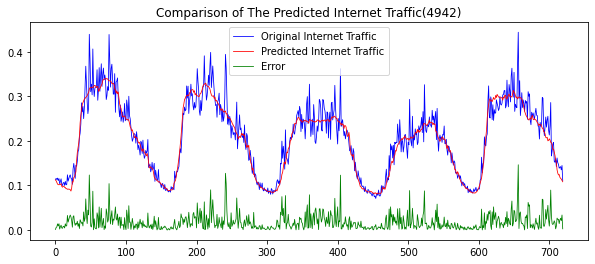

Absolute percentage error is =  0.08241815396198734
Absolute percentage mse is =  0.011418217885264308
Percentage rmse is =  0.10685606152794659


In [ ]:
#i = 120
fig = plt.figure(figsize=(10, 4))
#plt.subplot(1, 2, 1)
Cx = 50
Cy = 45
Z1 = yout[:,Cx,Cy]
#plt.imshow(Z1,cmap="hot")
plt.plot( Z1 ,color = 'blue', linewidth=0.8)
Z2 = valPredict[:,Cx,Cy]
plt.plot( Z2 ,color = 'red', linewidth=0.8)
#plt.imshow(Z2,cmap="hot")
plt.title("Original And Predicted Internet Traffic")
#plt.clim( 0,.5)

#plt.subplot(1, 2, 2)
Z3 = abs(Z2-Z1)
plt.plot( Z3 ,color = 'green', linewidth=0.8)

plt.title("Comparison of The Predicted Internet Traffic(4942)")
plt.legend(["Original Internet Traffic","Predicted Internet Traffic","Error"])
#plt.imshow(Z3,cmap="hot")
#plt.title("Error of The Predicted Internet Traffic")
#plt.clim( 0,.5)
plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/Spat4942_01_compare.png',transparent=True)
plt.show()

print('Absolute percentage error is = ' , absErrorOne(Z1 , Z2))
print('Absolute percentage mse is = ' , msepOne(Z1 , Z2))
print('Percentage rmse is = ' , (msepOne(Z1 , Z2))**0.5)

## ANN for single cell with Spatio output